In [1]:
# Cell 1 — Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

print("✔ Imports loaded")


✔ Imports loaded


In [3]:
# Cell 2 — Load features CSV

# Adjust path if needed (check in the sidebar /kaggle/input)
print("Input folders:", os.listdir("/kaggle/input"))

FEATURES_PATH = "/kaggle/input/features-csv/features.csv.csv"  # change if your dataset name is different
df = pd.read_csv(FEATURES_PATH)

print("✔ Data loaded:", df.shape)
df.head()


Input folders: ['features-csv']
✔ Data loaded: (34, 584)


,subject,file,segment,start_s,end_s,self_report,engagement_class,duration,mfcc_1_mean,mfcc_1_std,...,vfeat_508,vfeat_509,vfeat_510,vfeat_511,segment_high,segment_mid,segment_low,segment_read,segment_talk,segment_idle
0,sub01,sub01.mp4,high,3.0,31.0,5,high,28.0,-330.28217,38.383305,...,0.166632,0.802956,0.132247,0.196261,1.0,0.0,0.0,0.0,0.0,0.0
1,sub01,sub01.mp4,low,33.0,82.0,2,low,49.0,-377.83234,44.851612,...,0.210868,0.912421,0.103162,0.284469,0.0,0.0,1.0,0.0,0.0,0.0
2,sub01,sub01.mp4,talk,82.0,107.0,3,mid,25.0,-379.54200,44.595966,...,0.134236,0.938361,0.154042,0.236088,0.0,0.0,0.0,0.0,1.0,0.0
3,sub01,sub01.mp4,talk,107.0,146.0,4,high,39.0,-383.67667,37.099280,...,0.141579,1.036656,0.223603,0.341036,0.0,0.0,0.0,0.0,1.0,0.0
4,sub01,sub01.mp4,read,146.0,180.0,2,low,34.0,-378.46560,40.460320,...,0.127626,0.803469,0.112450,0.308088,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
# Cell 3 — Check engagement label distribution

print("3-class engagement distribution:")
print(df["engagement_class"].value_counts())


3-class engagement distribution:
engagement_class
high    18
low      9
mid      7
Name: count, dtype: int64


In [5]:
# Cell 4 — Build X (features) and y (3-class labels)

# Audio features
audio_cols = [
    c for c in df.columns
    if c.startswith("mfcc_")
    or c.startswith("spec_")
    or c.startswith("rolloff")
    or c.startswith("zcr")
    or c.startswith("chroma_")
]

# Meta features: duration + segment_* one-hot
meta_feat_cols = ["duration"] + [c for c in df.columns if c.startswith("segment_")]

X = df[audio_cols + meta_feat_cols].values

# 3-class labels: low / mid / high
y_text = df["engagement_class"].astype(str).values

le = LabelEncoder()
y = le.fit_transform(y_text)   # maps to 0,1,2 internally
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

print("✔ Feature matrix shape:", X.shape)
print("✔ Number of samples:", X.shape[0])


Label mapping: {'high': 0, 'low': 1, 'mid': 2}
✔ Feature matrix shape: (34, 65)
✔ Number of samples: 34


In [6]:
# Cell 5 — Majority-class baseline accuracy

majority_class = df["engagement_class"].value_counts().idxmax()
baseline_acc = (df["engagement_class"] == majority_class).mean()

print("Majority class:", majority_class)
print(f"Baseline accuracy (always predict '{majority_class}'): {baseline_acc:.3f}")


Majority class: high
Baseline accuracy (always predict 'high'): 0.529


In [9]:
# Cell 6 — Stratified K-Fold evaluation for multiclass

def eval_multiclass(pipeline, X, y, label_encoder, n_splits=5, verbose=True):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accs, f1s = [], []
    all_true, all_pred = [], []

    fold = 1
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")

        accs.append(acc)
        f1s.append(f1)
        all_true.extend(y_test)
        all_pred.extend(y_pred)

        if verbose:
            print(f"Fold {fold}: ACC={acc:.3f}, F1={f1:.3f}")
        fold += 1

    avg_acc = np.mean(accs)
    avg_f1 = np.mean(f1s)

    print("=" * 50)
    print(f"Stratified {n_splits}-Fold → ACC: {avg_acc:.3f}, F1 (macro): {avg_f1:.3f}")

    target_names = list(label_encoder.classes_)
    print("\nClassification report:")
    print(classification_report(all_true, all_pred, target_names=target_names))

    cm = confusion_matrix(all_true, all_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return avg_acc, avg_f1


=== Logistic Regression (multiclass) ===
Fold 1: ACC=0.571, F1=0.472
Fold 2: ACC=0.286, F1=0.167
Fold 3: ACC=0.429, F1=0.467
Fold 4: ACC=0.714, F1=0.675
Fold 5: ACC=0.333, F1=0.300
Stratified 5-Fold → ACC: 0.467, F1 (macro): 0.416

Classification report:
              precision    recall  f1-score   support

        high       0.62      0.56      0.59        18
         low       0.50      0.44      0.47         9
         mid       0.20      0.29      0.24         7

    accuracy                           0.47        34
   macro avg       0.44      0.43      0.43        34
weighted avg       0.50      0.47      0.48        34



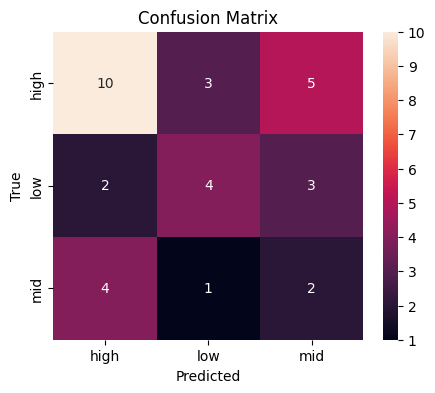

In [10]:
# Cell 7 — Logistic Regression (multiclass)

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5)),  # small PCA for stability; try 3–8
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        class_weight="balanced"
    ))
])

print("=== Logistic Regression (multiclass) ===")
acc_log, f1_log = eval_multiclass(logreg_pipe, X, y, le)


=== Random Forest (multiclass) ===
Fold 1: ACC=0.714, F1=0.463
Fold 2: ACC=0.429, F1=0.200
Fold 3: ACC=0.857, F1=0.630
Fold 4: ACC=0.571, F1=0.417
Fold 5: ACC=0.500, F1=0.413
Stratified 5-Fold → ACC: 0.614, F1 (macro): 0.424

Classification report:
              precision    recall  f1-score   support

        high       0.64      0.89      0.74        18
         low       0.50      0.33      0.40         9
         mid       0.67      0.29      0.40         7

    accuracy                           0.62        34
   macro avg       0.60      0.50      0.51        34
weighted avg       0.61      0.62      0.58        34



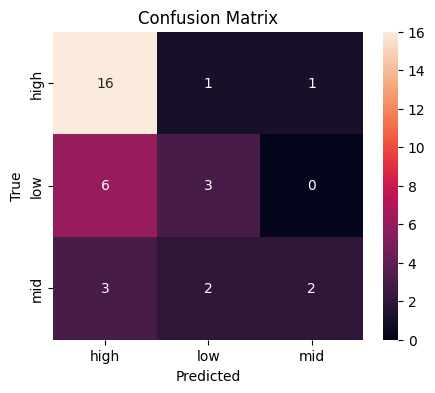

In [11]:
# Cell 8 — Random Forest (multiclass)

rf_pipe = Pipeline([
    ("scaler", StandardScaler()),  # RF doesn't need scaling, but harmless
    ("pca", PCA(n_components=10)), # can try 5–15
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42
    ))
])

print("=== Random Forest (multiclass) ===")
acc_rf, f1_rf = eval_multiclass(rf_pipe, X, y, le)


=== XGBoost grid search (multiclass) ===

Config: PCA=3, depth=3, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.414, F1 (macro): 0.277

Classification report:
              precision    recall  f1-score   support

        high       0.50      0.61      0.55        18
         low       0.38      0.33      0.35         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.41        34
   macro avg       0.29      0.31      0.30        34
weighted avg       0.36      0.41      0.38        34



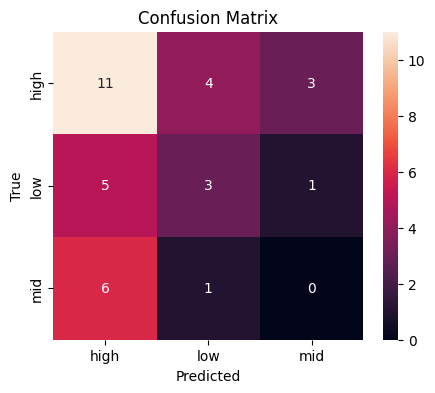

→ ACC=0.414, F1=0.277

Config: PCA=3, depth=3, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.471, F1 (macro): 0.322

Classification report:
              precision    recall  f1-score   support

        high       0.55      0.67      0.60        18
         low       0.50      0.44      0.47         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.47        34
   macro avg       0.35      0.37      0.36        34
weighted avg       0.42      0.47      0.44        34



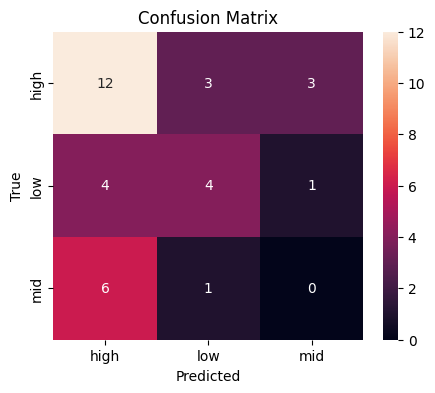

→ ACC=0.471, F1=0.322

Config: PCA=3, depth=3, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.414, F1 (macro): 0.282

Classification report:
              precision    recall  f1-score   support

        high       0.50      0.61      0.55        18
         low       0.43      0.33      0.38         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.41        34
   macro avg       0.31      0.31      0.31        34
weighted avg       0.38      0.41      0.39        34



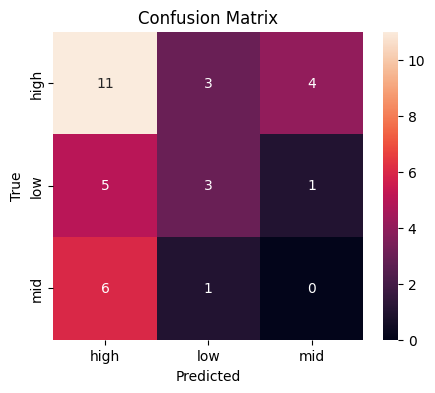

→ ACC=0.414, F1=0.282

Config: PCA=3, depth=3, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.443, F1 (macro): 0.308

Classification report:
              precision    recall  f1-score   support

        high       0.52      0.61      0.56        18
         low       0.50      0.44      0.47         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.44        34
   macro avg       0.34      0.35      0.34        34
weighted avg       0.41      0.44      0.42        34



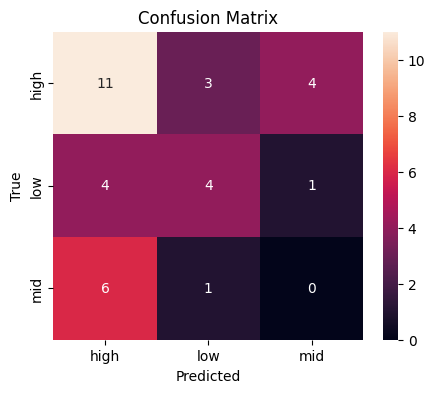

→ ACC=0.443, F1=0.308

Config: PCA=3, depth=4, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.414, F1 (macro): 0.277

Classification report:
              precision    recall  f1-score   support

        high       0.50      0.61      0.55        18
         low       0.38      0.33      0.35         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.41        34
   macro avg       0.29      0.31      0.30        34
weighted avg       0.36      0.41      0.38        34



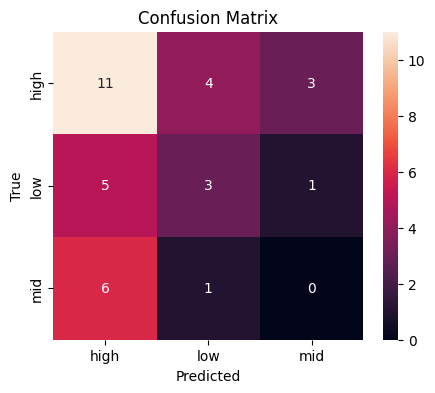

→ ACC=0.414, F1=0.277

Config: PCA=3, depth=4, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.471, F1 (macro): 0.322

Classification report:
              precision    recall  f1-score   support

        high       0.55      0.67      0.60        18
         low       0.50      0.44      0.47         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.47        34
   macro avg       0.35      0.37      0.36        34
weighted avg       0.42      0.47      0.44        34



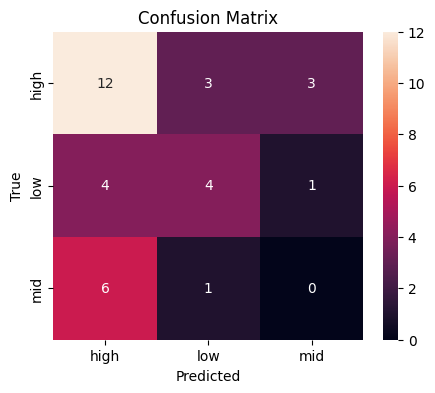

→ ACC=0.471, F1=0.322

Config: PCA=3, depth=4, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.443, F1 (macro): 0.302

Classification report:
              precision    recall  f1-score   support

        high       0.52      0.67      0.59        18
         low       0.50      0.33      0.40         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.44        34
   macro avg       0.34      0.33      0.33        34
weighted avg       0.41      0.44      0.42        34



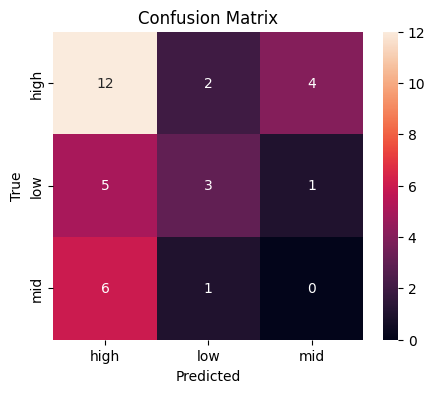

→ ACC=0.443, F1=0.302

Config: PCA=3, depth=4, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.443, F1 (macro): 0.311

Classification report:
              precision    recall  f1-score   support

        high       0.52      0.61      0.56        18
         low       0.57      0.44      0.50         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.44        34
   macro avg       0.37      0.35      0.35        34
weighted avg       0.43      0.44      0.43        34



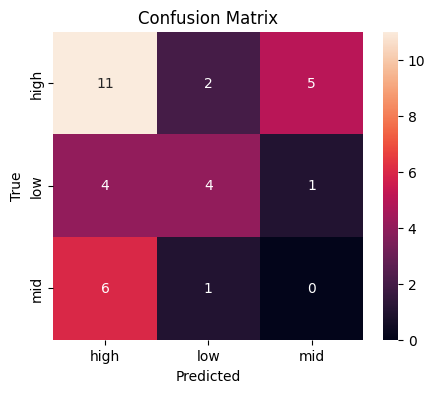

→ ACC=0.443, F1=0.311

Config: PCA=3, depth=5, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.414, F1 (macro): 0.277

Classification report:
              precision    recall  f1-score   support

        high       0.50      0.61      0.55        18
         low       0.38      0.33      0.35         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.41        34
   macro avg       0.29      0.31      0.30        34
weighted avg       0.36      0.41      0.38        34



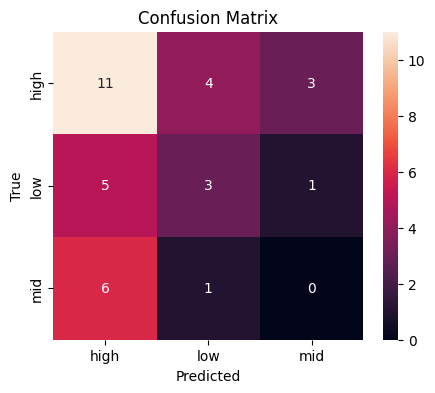

→ ACC=0.414, F1=0.277

Config: PCA=3, depth=5, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.471, F1 (macro): 0.322

Classification report:
              precision    recall  f1-score   support

        high       0.55      0.67      0.60        18
         low       0.50      0.44      0.47         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.47        34
   macro avg       0.35      0.37      0.36        34
weighted avg       0.42      0.47      0.44        34



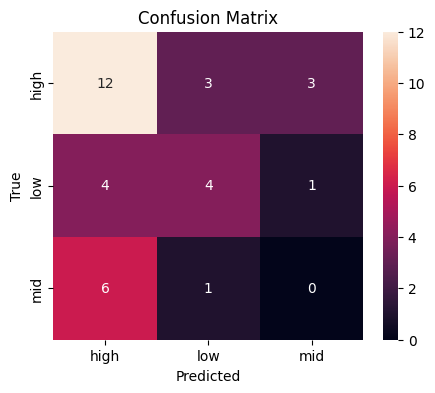

→ ACC=0.471, F1=0.322

Config: PCA=3, depth=5, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.471, F1 (macro): 0.322

Classification report:
              precision    recall  f1-score   support

        high       0.55      0.67      0.60        18
         low       0.50      0.44      0.47         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.47        34
   macro avg       0.35      0.37      0.36        34
weighted avg       0.42      0.47      0.44        34



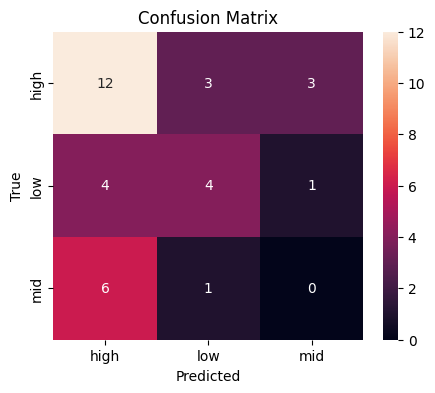

→ ACC=0.471, F1=0.322

Config: PCA=3, depth=5, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.471, F1 (macro): 0.329

Classification report:
              precision    recall  f1-score   support

        high       0.55      0.67      0.60        18
         low       0.57      0.44      0.50         9
         mid       0.00      0.00      0.00         7

    accuracy                           0.47        34
   macro avg       0.37      0.37      0.37        34
weighted avg       0.44      0.47      0.45        34



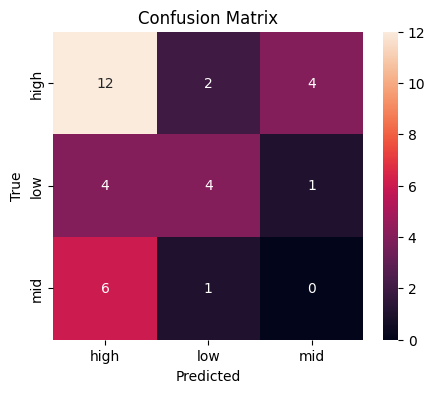

→ ACC=0.471, F1=0.329

Config: PCA=5, depth=3, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.393

Classification report:
              precision    recall  f1-score   support

        high       0.60      0.67      0.63        18
         low       0.43      0.33      0.38         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.50        34
   macro avg       0.44      0.43      0.43        34
weighted avg       0.49      0.50      0.49        34



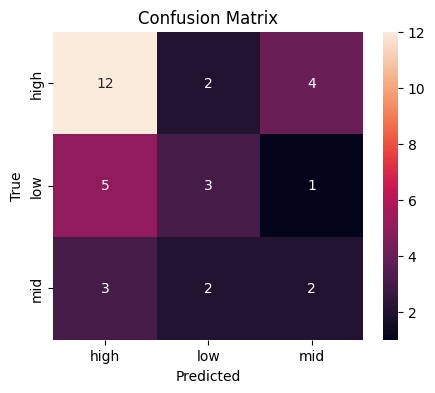

→ ACC=0.500, F1=0.393

Config: PCA=5, depth=3, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.533, F1 (macro): 0.433

Classification report:
              precision    recall  f1-score   support

        high       0.62      0.72      0.67        18
         low       0.43      0.33      0.38         9
         mid       0.33      0.29      0.31         7

    accuracy                           0.53        34
   macro avg       0.46      0.45      0.45        34
weighted avg       0.51      0.53      0.52        34



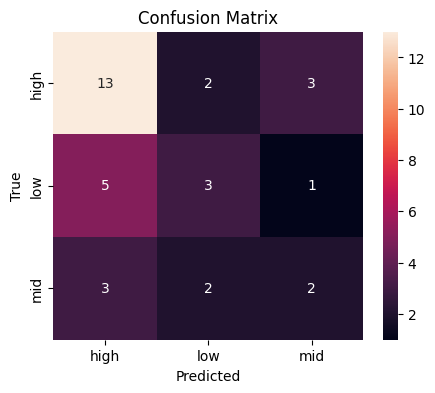

→ ACC=0.533, F1=0.433

Config: PCA=5, depth=3, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.393

Classification report:
              precision    recall  f1-score   support

        high       0.60      0.67      0.63        18
         low       0.43      0.33      0.38         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.50        34
   macro avg       0.44      0.43      0.43        34
weighted avg       0.49      0.50      0.49        34



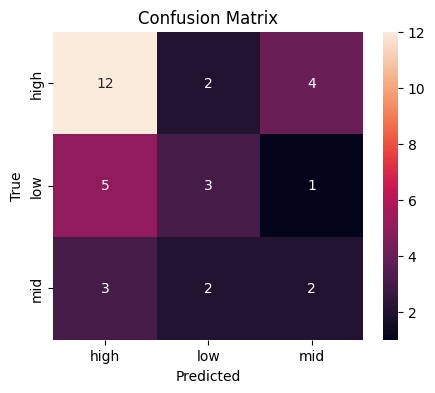

→ ACC=0.500, F1=0.393

Config: PCA=5, depth=3, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.394

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.33      0.22      0.27         9
         mid       0.33      0.29      0.31         7

    accuracy                           0.50        34
   macro avg       0.42      0.41      0.41        34
weighted avg       0.47      0.50      0.48        34



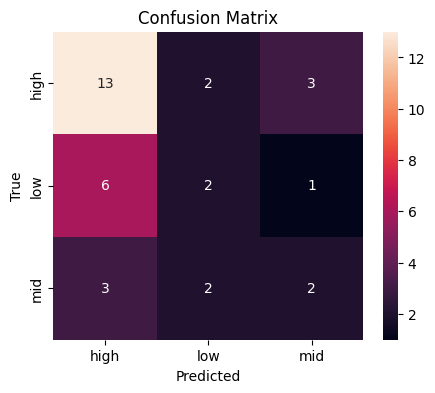

→ ACC=0.500, F1=0.394

Config: PCA=5, depth=4, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.393

Classification report:
              precision    recall  f1-score   support

        high       0.60      0.67      0.63        18
         low       0.43      0.33      0.38         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.50        34
   macro avg       0.44      0.43      0.43        34
weighted avg       0.49      0.50      0.49        34



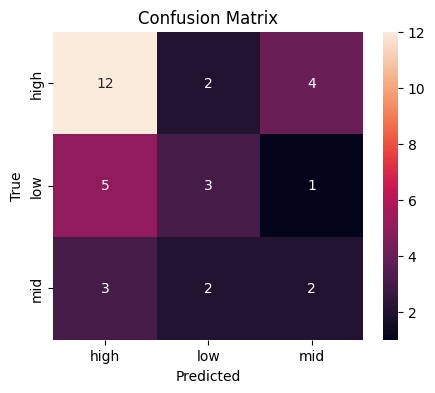

→ ACC=0.500, F1=0.393

Config: PCA=5, depth=4, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.467, F1 (macro): 0.356

Classification report:
              precision    recall  f1-score   support

        high       0.57      0.67      0.62        18
         low       0.33      0.22      0.27         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.47        34
   macro avg       0.40      0.39      0.39        34
weighted avg       0.45      0.47      0.46        34



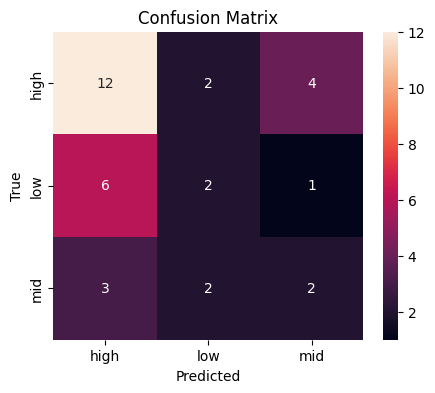

→ ACC=0.467, F1=0.356

Config: PCA=5, depth=4, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.393

Classification report:
              precision    recall  f1-score   support

        high       0.60      0.67      0.63        18
         low       0.43      0.33      0.38         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.50        34
   macro avg       0.44      0.43      0.43        34
weighted avg       0.49      0.50      0.49        34



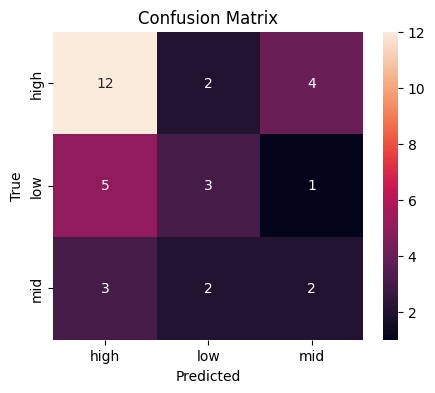

→ ACC=0.500, F1=0.393

Config: PCA=5, depth=4, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.394

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.33      0.22      0.27         9
         mid       0.33      0.29      0.31         7

    accuracy                           0.50        34
   macro avg       0.42      0.41      0.41        34
weighted avg       0.47      0.50      0.48        34



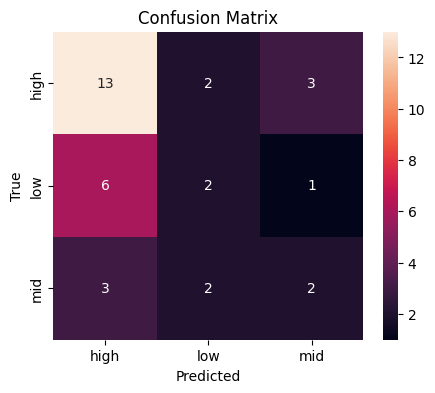

→ ACC=0.500, F1=0.394

Config: PCA=5, depth=5, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.393

Classification report:
              precision    recall  f1-score   support

        high       0.60      0.67      0.63        18
         low       0.43      0.33      0.38         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.50        34
   macro avg       0.44      0.43      0.43        34
weighted avg       0.49      0.50      0.49        34



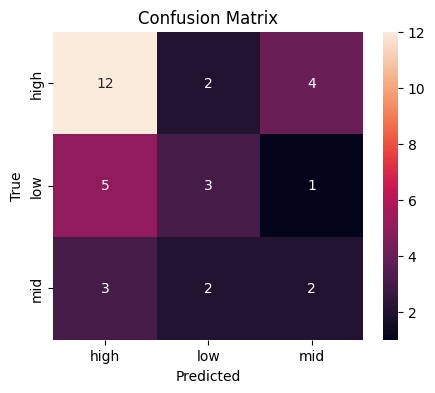

→ ACC=0.500, F1=0.393

Config: PCA=5, depth=5, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.467, F1 (macro): 0.356

Classification report:
              precision    recall  f1-score   support

        high       0.57      0.67      0.62        18
         low       0.33      0.22      0.27         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.47        34
   macro avg       0.40      0.39      0.39        34
weighted avg       0.45      0.47      0.46        34



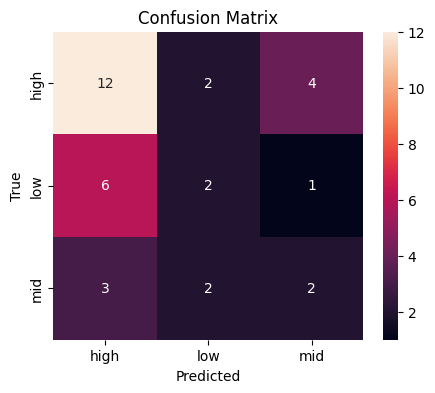

→ ACC=0.467, F1=0.356

Config: PCA=5, depth=5, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.393

Classification report:
              precision    recall  f1-score   support

        high       0.60      0.67      0.63        18
         low       0.43      0.33      0.38         9
         mid       0.29      0.29      0.29         7

    accuracy                           0.50        34
   macro avg       0.44      0.43      0.43        34
weighted avg       0.49      0.50      0.49        34



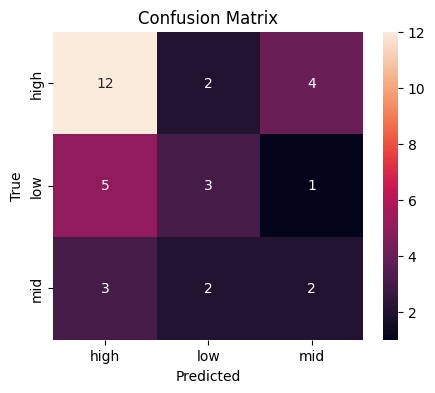

→ ACC=0.500, F1=0.393

Config: PCA=5, depth=5, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.500, F1 (macro): 0.394

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.33      0.22      0.27         9
         mid       0.33      0.29      0.31         7

    accuracy                           0.50        34
   macro avg       0.42      0.41      0.41        34
weighted avg       0.47      0.50      0.48        34



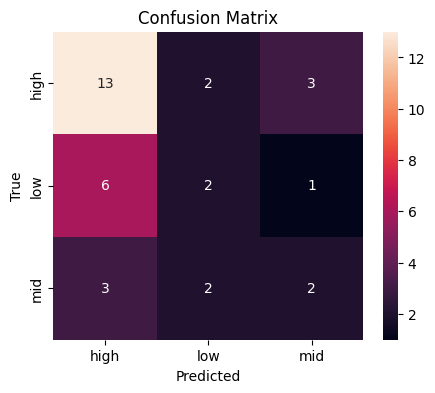

→ ACC=0.500, F1=0.394

Config: PCA=8, depth=3, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.533, F1 (macro): 0.389

Classification report:
              precision    recall  f1-score   support

        high       0.57      0.72      0.63        18
         low       0.50      0.33      0.40         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.53        34
   macro avg       0.49      0.45      0.46        34
weighted avg       0.51      0.53      0.51        34



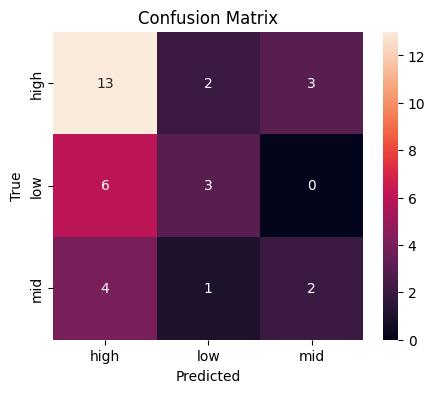

→ ACC=0.533, F1=0.389

Config: PCA=8, depth=3, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



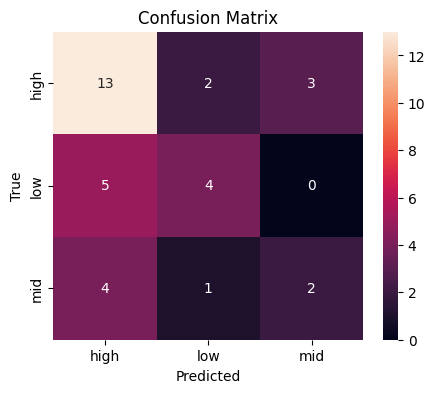

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=3, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



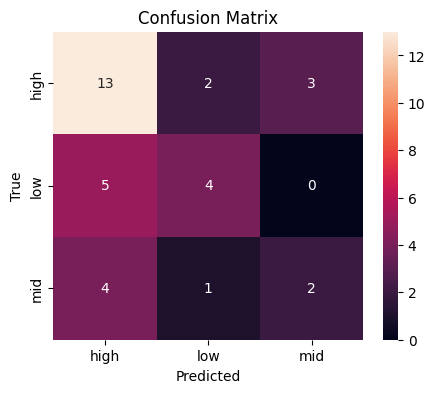

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=3, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



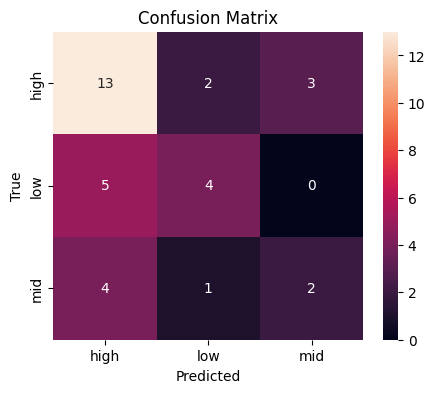

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=4, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



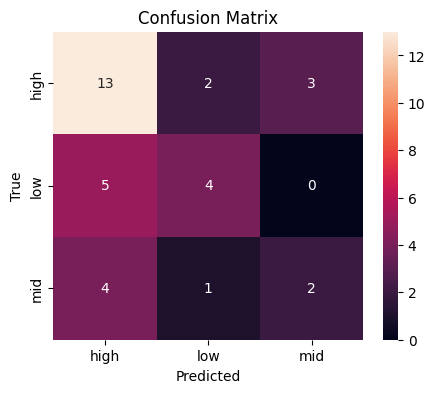

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=4, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



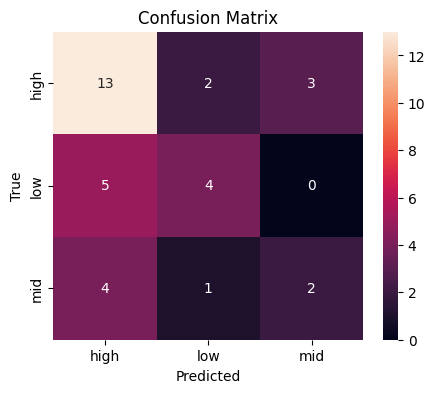

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=4, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



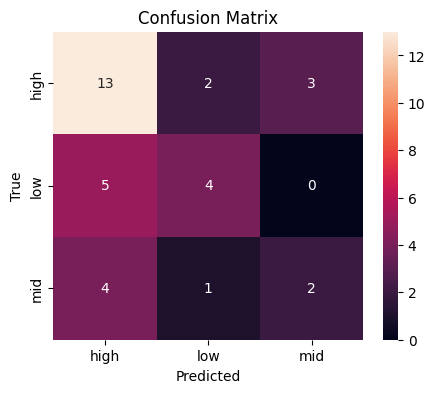

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=4, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



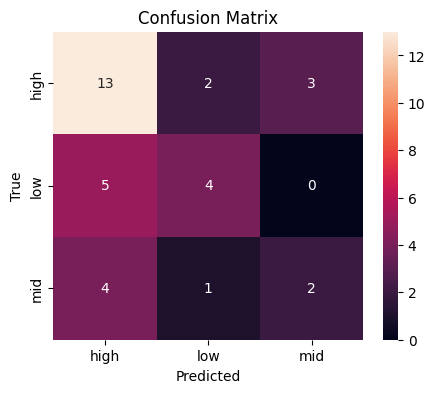

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=5, lr=0.05, n_est=200
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



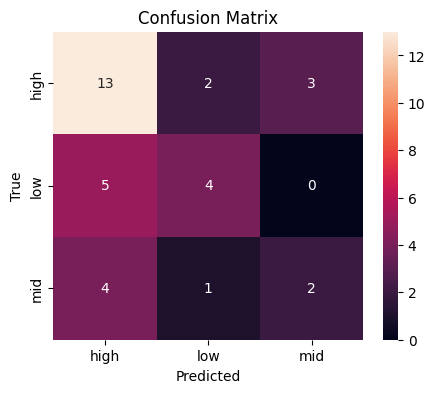

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=5, lr=0.05, n_est=400
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



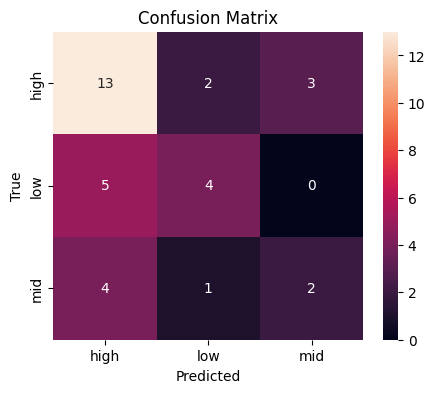

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=5, lr=0.1, n_est=200
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



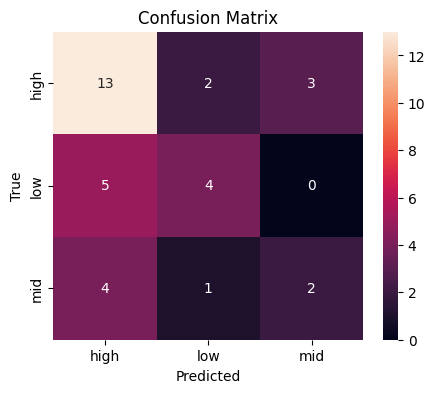

→ ACC=0.562, F1=0.419

Config: PCA=8, depth=5, lr=0.1, n_est=400
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



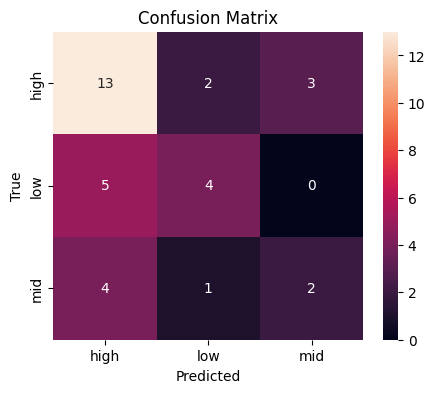

→ ACC=0.562, F1=0.419

=== Best XGBoost config (by ACC) ===
PCA components: 8
Max depth     : 3
Learning rate : 0.05
Estimators    : 400
Best ACC=0.562, Best F1=0.419


In [12]:
# Cell 9 — Small XGBoost grid search (multiclass)

configs = []
results = []

pca_components_list = [3, 5, 8]       # try small dimensions
max_depth_list      = [3, 4, 5]
lr_list             = [0.05, 0.1]
n_estimators_list   = [200, 400]

print("=== XGBoost grid search (multiclass) ===")

for n_comp in pca_components_list:
    for depth in max_depth_list:
        for lr in lr_list:
            for n_est in n_estimators_list:
                xgb_pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("pca", PCA(n_components=n_comp)),
                    ("clf", xgb.XGBClassifier(
                        n_estimators=n_est,
                        max_depth=depth,
                        learning_rate=lr,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective="multi:softprob",
                        num_class=len(le.classes_),
                        eval_metric="mlogloss",
                        random_state=42
                    ))
                ])

                print(f"\nConfig: PCA={n_comp}, depth={depth}, lr={lr}, n_est={n_est}")
                acc_xgb, f1_xgb = eval_multiclass(xgb_pipe, X, y, le, verbose=False)
                print(f"→ ACC={acc_xgb:.3f}, F1={f1_xgb:.3f}")

                configs.append((n_comp, depth, lr, n_est))
                results.append((acc_xgb, f1_xgb))

# Find best config
results_arr = np.array(results)
best_idx = np.argmax(results_arr[:, 0])  # choose by accuracy (or use F1 if you prefer)
best_acc, best_f1 = results_arr[best_idx]
best_cfg = configs[best_idx]

print("\n=== Best XGBoost config (by ACC) ===")
print("PCA components:", best_cfg[0])
print("Max depth     :", best_cfg[1])
print("Learning rate :", best_cfg[2])
print("Estimators    :", best_cfg[3])
print(f"Best ACC={best_acc:.3f}, Best F1={best_f1:.3f}")


=== Final XGBoost (multiclass, best config) ===
Fold 1: ACC=0.429, F1=0.389
Fold 2: ACC=0.429, F1=0.300
Fold 3: ACC=0.714, F1=0.517
Fold 4: ACC=0.571, F1=0.417
Fold 5: ACC=0.667, F1=0.472
Stratified 5-Fold → ACC: 0.562, F1 (macro): 0.419

Classification report:
              precision    recall  f1-score   support

        high       0.59      0.72      0.65        18
         low       0.57      0.44      0.50         9
         mid       0.40      0.29      0.33         7

    accuracy                           0.56        34
   macro avg       0.52      0.48      0.49        34
weighted avg       0.55      0.56      0.55        34



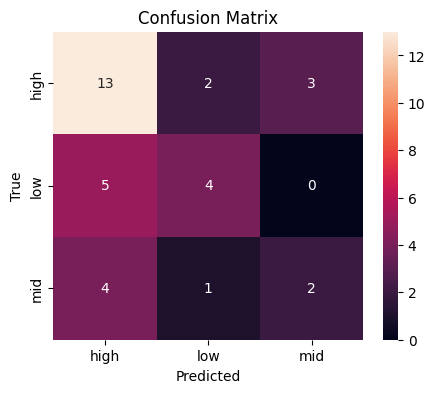

In [13]:
# Cell 10 — Final XGBoost with best config

best_n_comp, best_depth, best_lr, best_n_est = best_cfg

xgb_best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=best_n_comp)),
    ("clf", xgb.XGBClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        learning_rate=best_lr,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        random_state=42
    ))
])

print("=== Final XGBoost (multiclass, best config) ===")
acc_best, f1_best = eval_multiclass(xgb_best_pipe, X, y, le)


In [14]:
# Cell 11 — Compare models

results_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "XGBoost (best grid)"
    ],
    "Accuracy": [
        acc_log,
        acc_rf,
        best_acc
    ],
    "F1_macro": [
        f1_log,
        f1_rf,
        best_f1
    ]
})

print(" Final Model Performance (3-class)")
results_df


📊 Final Model Performance (3-class)


,Model,Accuracy,F1_macro
0,Logistic Regression,0.466667,0.416032
1,Random Forest,0.614286,0.424392
2,XGBoost (best grid),0.561905,0.418889
